<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/soft_ware_labs/soft_landing_guidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Soft landing guidance

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE6029: Linear Optimal Control, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_
_<div style="text-align: right"> Jiwoo Choi (jiwoochoi@inha.edu) </div>_

<br>

We consider a soft landing problem for a rocket. The particle mass dynamics for each coordinate in ENU (East-North-Up) frame is governed by

$$
\begin{aligned}
  \dot{v_e} &= u_e - \gamma v_e  \\
  \dot{p_e} &= v_e \\  
  \dot{v_n} &= u_n - \gamma v_n  \\
  \dot{p_n} &= v_n \\  
  \dot{v_u} &= u_u - \gamma v_u - g\\
  \dot{p_u} &= v_u
\end{aligned}
$$

Denoting the velocity, position, gravity vector in ENU frame by $v=(v_e,v_n,v_u)$, $p=(p_e,p_n,p_u)$, $g=(0,0,-g)$, the damping coefficient by $\gamma$, the trapezoidal integration assuming constant acceleration during the sampling interval gives,

$$
\begin{aligned}
  v_{t+1} &= v_t + {h}\left( u_t - \gamma v_t -g \right) \\
  &= \left(1-\gamma h\right) v_t + h u_t - hg \\
  p_{t+1} &= p_t + \frac{h}{2}\left( v_t + v_{t+1} \right)  \\
  &= p_t + \frac{h}{2}\left( v_t + \left(1-\gamma h\right) v_t + h u_t \right)  \\
  &= p_t +  \left(h-\frac{1}{2}\gamma h^2\right) v_t + \frac{1}{2} h^2 u_t
\end{aligned}
$$

Then with $x = (p_e,p_n,p_u,v_e,v_n,v_u)$ the above dynamics can be coded into the following:

$$
\begin{aligned}
  x_{t+1} &= Ax_t + Bu_t
\end{aligned}
$$

In other words,

$$
\bmat{p_e \\ p_n \\ p_u \\ v_e \\ v_n \\ v_u }_{t+1} = \underbrace{\bmat{
1 & 0 & 0 & \left(1-0.5\gamma h\right)h & 0 & 0 \\
0 & 1 & 0 & 0 & \left(1-0.5\gamma h\right)h & 0 \\
0 & 0 & 1 & 0 & 0 & \left(1-0.5\gamma h\right)h \\
0 & 0 & 0 & 1-\gamma h & 0 & 0 \\
0 & 0 & 0 & 0 & 1-\gamma h & 0 \\
0 & 0 & 0 & 0 & 0 & 1-\gamma h
}}_{A}
\bmat{p_e \\ p_n \\ p_u \\ v_e \\ v_n \\ v_u}_t + \underbrace{\bmat{
0.5h^2 & 0 & 0 \\
0 & 0.5h^2 & 0 \\
0 & 0 & 0.5h^2 \\
h & 0 & 0 \\
0 & h & 0 \\
0 & 0 & h
}}_{B} \bmat{u_e \\ u_n \\ u_u }_t
+ \underbrace{\bmat{0 \\ 0 \\ -0.5h^2g \\ 0 \\ 0 \\ -hg}}_{b}
$$

The rocket is initially at $x_0 = (500,200,2000,40,-10,-300)$, and we consider a finite horizon of $T=20$ with $N=200$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
from scipy.linalg import sqrtm

N = 200 # number of timesteps
T = 20 # time will vary from 0 to T with stepsize h
ts = np.linspace(0,T,N+1)
h = T/N
gamma = .05 # damping, 0 is no damping
g = 9.8

n = 6   # state size
m = 3   # control size

I3 = ssp.eye(3)

A = ssp.bmat([[I3, (1-gamma*h/2)*h*I3], \
              [None,   (1-gamma*h)*I3]])
B = ssp.bmat([[h**2/2*I3], \
              [     h*I3]])
b = np.array([0,0,-0.5*g*h**2,0,0,-g*h])

x_0 = np.array([500,200,2000,40,-10,-300])

<br>

We formulate the soft landing problem via linear quadratic regulator design problem.
With the design parameters $Q_1,\dots,Q_N \ge 0$ and $R_0,\dots,R_{N-1}>0$, the LQR problem can be stated as follows (we can omit the first stage cost term $x_0^TQ_0 x_0$).

$$
\begin{aligned}
  \underset{u,x}{\minimize} \quad & \sum_{t=0}^{N-1} \left( x_t^TQ_tx_t + u_t^TR_tu_t \right) + x_N^TQ_Nx_N \\
  \text{subject to} \quad & x_{t+1} = Ax_t + Bu_t + b, \quad\forall t=0,\dots,N-1,
\end{aligned}
$$

<br>

We define time-varying $Q$ such that
$$
Q_t = \bmat{
10e^{-(N-t)/10} \\
& 10e^{-(N-t)/10} \\
& & 0 \\
& & & 100e^{-(N-t)/10} \\
& & & & 100e^{-(N-t)/10} \\
& & & & & 0
}
$$
for $t=0,\dots,N-1$ along with
$$
Q_N = \bmat{
10 \\
& 10 \\
& & 100 \\
& & & 100 \\
& & & & 100 \\
& & & & & 1000
}
$$

and $R_t=I$ for all $t$.


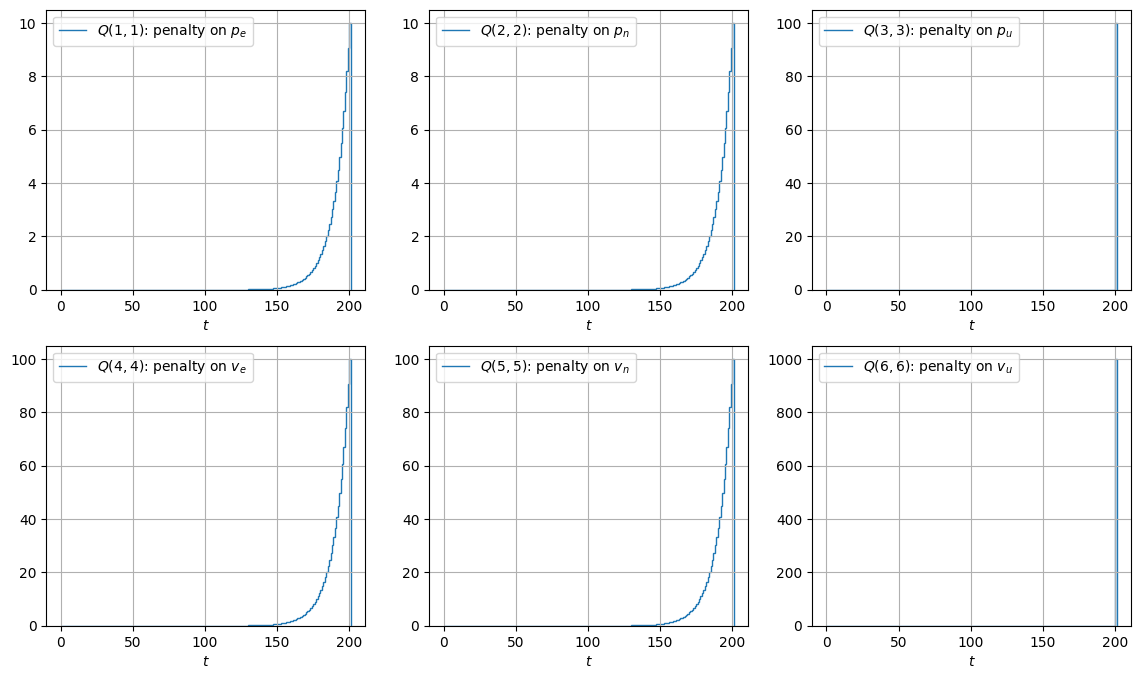

In [2]:
Q = []
R = []
Q_tilde = []
R_tilde = []
for t in range(N):
  Qt = np.exp(-(N-t)/10)*ssp.diags([10,10,  0,100,100,   0])
  Rt = ssp.eye(m)
  Q.append(Qt)
  R.append(Rt)
Q.append(ssp.diags([ 10,10,100,100,100,1000]))

labels = [r'$p_e$',r'$p_n$',r'$p_u$',r'$v_e$',r'$v_n$',r'$v_u$',
          r'$u_e$',r'$u_n$',r'$u_u$']

plt.figure(figsize=(14,8), dpi=100)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.stairs([q.toarray()[i,i] for q in Q], label=rf'$Q({i+1},{i+1})$: penalty on {labels[i]}')
  plt.legend()
  plt.grid()
  plt.xlabel(r'$t$')
plt.show()

In [3]:
# draw plots
def draw_plots(t1,x1,u1,t2=[],x2=[],u2=[]):
  # t1: time, (N+1,)-vector
  # x1: state trajectory, 6x(N+1) matrix
  # u1: control vector, 3xN matrix
  # t2, x2, u2: optional for comparing two trajectories, size same as above

  labels = [r'$p_e$',r'$p_n$',r'$p_u$',r'$v_e$',r'$v_n$',r'$v_u$',
            r'$u_e$',r'$u_n$',r'$u_u$']
  plt.figure(figsize=(14,9), dpi=100)
  for i in range(6):
    plt.subplot(3,3,i+1)
    plt.plot(t1,x1[i],label=labels[i])
    if len(t2):
      plt.plot(t2,x2[i])
    plt.legend()
    plt.grid()
  for i in range(3):
    plt.subplot(3,3,i+7)
    plt.plot(t1[:-1],u1[i],label=labels[i+6])
    if len(t2):
      plt.plot(t2[:-1],u2[i])
    plt.xlabel(r'$t$')
    plt.legend()
    plt.grid()
  plt.show()
  return

# draw 3D plot
def draw_3d_traj(x1,u1,x2=[],u2=[]):
  # x1: state trajectory, 6x(N+1) matrix
  # u1: control vector, 3xN matrix
  # x2, u2: optional for comparing two trajectories, size same as above

  fig = plt.figure(figsize=(10,10), dpi=100)
  ax  = fig.add_subplot(projection='3d')
  ax.view_init(elev=10, azim=-75, roll=0)
  _ = 10

  N = x1.shape[1]-1
  ax.plot(*x1[:3,:])
  if len(x2):
    ax.plot(*x2[:3,:])
  for i in range(0, N, 10):
    __ = np.linalg.norm(u1[:,i])/200
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],-u1[0,i]*_,-u1[1,i]*_,-u1[2,i]*_, \
              color='magenta', linewidths=1, arrow_length_ratio = 0)
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],u1[0,i]/__,u1[1,i]/__,u1[2,i]/__, \
              color='gray', linewidths=1, arrow_length_ratio = 0)
    if len(x2):
      __ = np.linalg.norm(u2[:,i])/200
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],-u2[0,i]*_,-u2[1,i]*_,-u2[2,i]*_, \
                color='red', linewidths=1, arrow_length_ratio = 0)
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],u2[0,i]/__,u2[1,i]/__,u2[2,i]/__, \
                color='black', linewidths=1, arrow_length_ratio = 0)

  th = np.linspace(0,2*np.pi)
  ax.plot(100*np.cos(th),100*np.sin(th),0,alpha=0.5,color='green')
  ax.plot(200*np.cos(th),200*np.sin(th),0,alpha=0.5,color='green')
  ax.set_xlabel(r'$p_e$')
  ax.set_ylabel(r'$p_n$')
  ax.set_zlabel(r'$p_u$')
  ax.axis('equal')
  plt.show()
  return

In [4]:
# make 3D animation
!pip install celluloid

from celluloid import Camera
from matplotlib import rc

def make_3d_anim(x1,u1,x2=[],u2=[],playback_speed=2):
  # x1: state trajectory, 6x(N+1) matrix
  # u1: control vector, 3xN matrix
  # x2, u2: optional for comparing two trajectories, size same as above

  fig = plt.figure(figsize=(10,10), dpi=100)
  ax = fig.add_subplot(projection='3d')
  ax.view_init(elev=10, azim=-75, roll=0)
  _ = 10

  N = x1.shape[1]-1
  camera = Camera(fig)
  for i in range(0,N,playback_speed):
    ax.plot(*x1[:3,:], alpha=0.2)
    if len(x2):
      ax.plot(*x2[:3,:], alpha=0.2)
    __ = np.linalg.norm(u1[:,i])/200
    ax.plot(x1[0,:i+1],x1[1,:i+1],x1[2,:i+1])
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],-u1[0,i]*_,-u1[1,i]*_,-u1[2,i]*_, \
              color='magenta', linewidths=2, arrow_length_ratio = 0)
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],u1[0,i]/__,u1[1,i]/__,u1[2,i]/__, \
              color='gray', linewidths=4, arrow_length_ratio = 0)
    if len(x2):
      __ = np.linalg.norm(u2[:,i])/200
      ax.plot(x2[0,:i+1],x2[1,:i+1],x2[2,:i+1])
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],-u2[0,i]*_,-u2[1,i]*_,-u2[2,i]*_, \
                color='red', linewidths=2, arrow_length_ratio = 0)
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],u2[0,i]/__,u2[1,i]/__,u2[2,i]/__, \
                color='black', linewidths=4, arrow_length_ratio = 0)

    th = np.linspace(0,2*np.pi)
    ax.plot(100*np.cos(th),100*np.sin(th),0,alpha=0.5,color='green')
    ax.plot(200*np.cos(th),200*np.sin(th),0,alpha=0.5,color='green')
    ax.set_xlabel(r'$p_e$')
    ax.set_ylabel(r'$p_n$')
    ax.set_zlabel(r'$p_u$')
    ax.axis( 'equal')

    camera.snap()

  plt.close()
  anim = camera.animate(blit=False, interval=100)
  rc('animation', html='jshtml')
  return anim

<br>

## Soft landing LQR by least squares

_**(Problem 1)**_ Find the optimal maneuver acceration for the above LQR problem via least squares solutions. Report the terminal position and the terminal velocity at touchdown.

In [7]:
import numpy as np
import scipy.sparse as ssp
import scipy.sparse.linalg as sla

# Given: A, B, b, Q, R, x_0 (from your code snippet)
# We have Q: length N+1; Q[0],...,Q[N-1], Q[N]
# We have R: length N; R[0],...,R[N-1]

# Construct big matrices
# Dimensions:
# X in R^{n*(N+1)}, U in R^{m*N}
# The dynamics constraints:
# x_{t+1} - A x_t - B u_t = b
# We can form a big matrix equation:
#
# [ I      0      0    ...   0 ]   [ x_0 ]   [     0     ]
# [-A      I      0    ...   0 ]   [ x_1 ]   [     b     ]
# [ 0     -A      I    ...   0 ] * [ x_2 ] = [     b     ]
#  ...                                ...
# [ 0      ...         -A  I ]   [ x_N ]   [     b     ]
#
# plus the terms for u_t in a similar fashion.

# State-size and control-size
n = 6
m = 3

# Construct block matrices for dynamics
# We know x_0 is fixed, so we separate it out.
# We'll form the system: X = F x_0 + G U + H
# Let's create G and H first.

# Create G
row_blocks = []
col_blocks = []
offset = 0
for t in range(N):
    # Each row block corresponds to x_{t+1}
    # x_{t+1} = A x_t + B u_t + b
    # So at row-block t (for x_{t+1}):
    # X-part: depends on x_t
    # U-part: depends on u_t
    # We'll handle them later in a more straightforward manner.
    pass

# Instead of manually constructing, let's do a straightforward approach:

# Big A matrix for states only (without control):
# X_{1:} = bigA * X_{0:N} + bigB * U + bstacked
# bigA is block lower-triangular with -A on the subdiagonal and I on diagonal blocks.

I_n = ssp.eye(n)
zero_n = ssp.csr_matrix((n,n))
# For X:
# We have N equations (from t=0 to t=N-1) linking X_{t+1} and X_t
# The "state transition" matrix for the stacked system:
# [ x_0 ] (given)
# [ x_1 ] = A x_0 + B u_0 + b
# [ x_2 ] = A x_1 + B u_1 + b
# ...
# X can be written in terms of x_0 and U by forward substitution.

# Let's do forward elimination form:
X_sol = [x_0]
U_opt = np.zeros((m,N))  # will store solution after solve

# Construct the big Q and R
Qbig = ssp.block_diag(Q)
Rbig = ssp.block_diag(R)

# Construct matrices for least squares:
# The key step: express X in terms of U.
# X_0 = x_0 given
# x_{1} = A x_0 + B u_0 + b
# x_{2} = A x_1 + B u_1 + b = A(Ax_0 + Bu_0 + b) + B u_1 + b = A^2 x_0 + A B u_0 + A b + B u_1 + b
# ...
# In general:
# x_t = A^t x_0 + sum_{k=0}^{t-1} A^{t-1-k} (B u_k + b)
#
# We can precompute powers of A and handle b similarly.

Apow = [ssp.eye(n)]
for i in range(1,N+1):
    Apow.append(A.dot(Apow[-1]))

# Compute linear mappings:
# X = [x_0; x_1; ...; x_N]
#   = F x_0 + G U + H
#
# F x_0:
F = []
for t in range(N+1):
    # x_t = A^t x_0 + ... we will add control and b terms later
    F.append(Apow[t].dot(x_0))
F = np.vstack(F)  # shape: (n*(N+1),)
F = F.reshape(-1) # shape (6*(N+1),)
# H from b:
# Summation (I + A + A^2 + ... A^{t-1}) b for each x_t
H_list = []
for t in range(N+1):
    hb = np.zeros(n)
    for k in range(t):
        hb += Apow[t-1-k].dot(b)
    H_list.append(hb)
H = np.vstack(H_list)  # shape: (n*(N+1),)
H = H.reshape(-1)      # shape (6*(N+1),)
# G from U:
# x_t depends on all u_k with k < t:
# x_t includes terms: sum_{k=0}^{t-1} A^{t-1-k} B u_k
G_block = []
for t in range(N+1):
    row_blocks = []
    for k in range(N):
        if k < t:
            row_blocks.append(Apow[t-1-k].dot(B).toarray())
        else:
            row_blocks.append(np.zeros((n,m)))
    G_block.append(np.hstack(row_blocks))
G = np.vstack(G_block)  # shape: (n*(N+1), m*N)

# We do not need the first row of the cost for x_0 since Q_0 x_0 x_0 is a constant.
# Actually, we keep it; it only adds a constant to the cost. Minimization unaffected.

# Now the cost:
# J = X^T Qbig X + U^T Rbig U
#   = (F x_0 + G U + H)^T Qbig (F x_0 + G U + H) + U^T Rbig U
#
# Collect terms in U:
# J(U) = U^T (G^T Qbig G + Rbig) U + 2(Fx_0+H)^T Qbig G U + const
#
# Normal equations:
# (G^T Qbig G + Rbig) U = - G^T Qbig (F x_0 + H)

lhs = G.T.dot(Qbig.dot(G)) + Rbig
rhs = -G.T.dot(Qbig.dot(F + H))

U_star = sla.spsolve(lhs, rhs)  # solve for U

U_opt = U_star.reshape((m,N), order='F')

# Compute state trajectory:
X_opt = (F + H) + G.dot(U_star)  # dimension n*(N+1)
X_opt = X_opt.reshape((N+1,n)).T

# Report terminal position and velocity:
p_final = X_opt[0:3,-1]  # p_e, p_n, p_u at t=N
v_final = X_opt[3:6,-1]  # v_e, v_n, v_u at t=N

print("Terminal position:", p_final)
print("Terminal velocity:", v_final)


Terminal position: [ 0.08685164  0.00873732 -0.17587069]
Terminal velocity: [-0.00108027 -0.00010868 -0.10731695]


<ipython-input-7-9eaaa493a159>:137: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  U_star = sla.spsolve(lhs, rhs)  # solve for U


In [ ]:
##################
# your code here


# your code here
##################

terminal position: [ 0.08685164  0.00873732 -0.17587069]
terminal velocity: [-0.00108027 -0.00010868 -0.10731695]


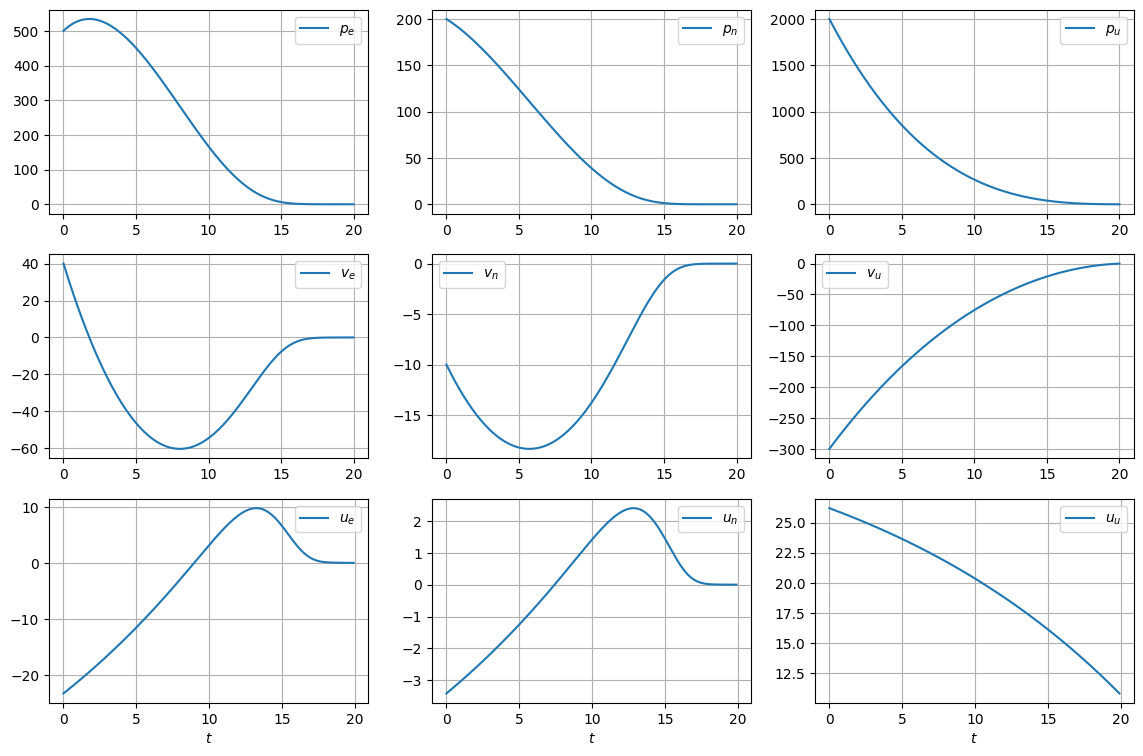

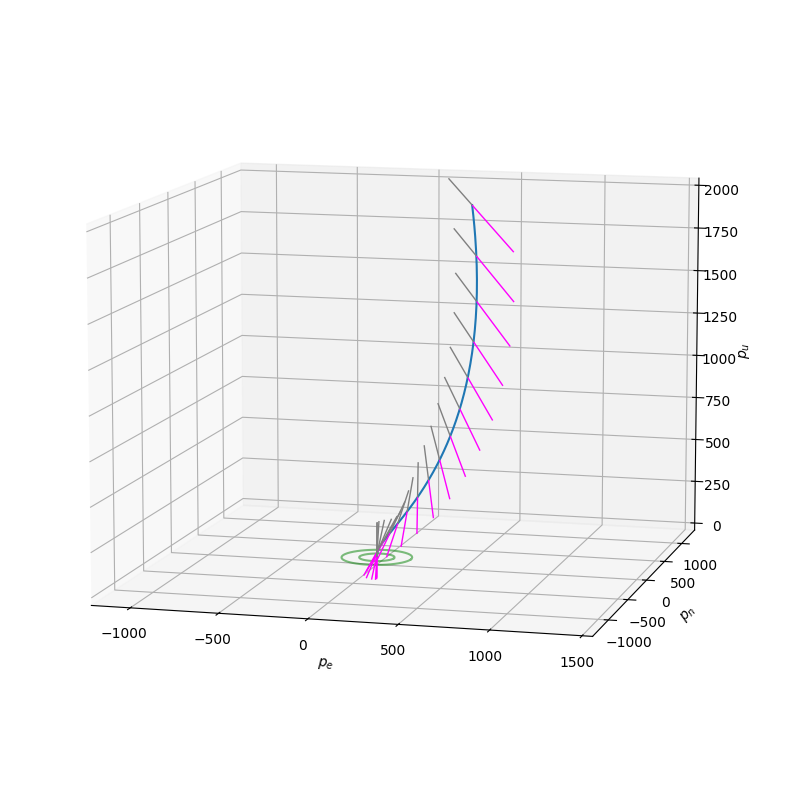

In [8]:
# draw plots
draw_plots(ts,X_opt,U_opt )
draw_3d_traj(X_opt,U_opt )

<br>

## Soft landing LQR by Riccati recursion via dynamic programming

_**(Problem 2)**_ Find the optimal maneuver acceration for the above LQR problem by Riccati recursion via dynamic programming. Compare your solution with the least squares solution obtained from above.

In [30]:
print("A shape:", A.shape)
print("P[t+1] shape:", P[t+1].shape)
print("B shape:", B.shape)
print("S_inv shape:", S_inv.shape)
at = s[t+1] + P[t+1] @ b
at = np.array(at).reshape(-1)  # 확실히 1D numpy 배열로 변환
print("(B.T @ at) shape:", (B.T @ at).shape)

A shape: (6, 6)
P[t+1] shape: (6, 6)
B shape: (6, 3)
S_inv shape: (3, 3)
(B.T @ at) shape: (3,)


In [33]:

# Riccati 역방향 계산
P[N] = Q[N]
s[N] = np.zeros(n)

for t in range(N-1, -1, -1):
    Rt = R[t]
    Qt = Q[t]

    # S 계산
    S = Rt + B.T @ P[t+1] @ B
    S_inv = np.linalg.inv(S)

    # P_t 업데이트
    P[t] = Qt + A.T @ P[t+1] @ A - A.T @ P[t+1] @ B @ S_inv @ B.T @ P[t+1] @ A

    # s_t 업데이트
    at = s[t+1] + P[t+1] @ b
    at = np.array(at).ravel()  # 명시적으로 1D 배열로 변환
    s[t] = A.T @ at - A.T @ P[t+1] @ B @ S_inv @ (B.T @ at)

# 피드백 이득 계산
K = []
k = []
for t in range(N):
    S = R[t] + B.T @ P[t+1] @ B
    S_inv = np.linalg.inv(S)
    Kt = -S_inv @ B.T @ P[t+1] @ A
    at = s[t+1] + P[t+1] @ b
    at = np.array(at).ravel()
    kt = -S_inv @ (B.T @ at)
    K.append(Kt)
    k.append(kt)

# 전방 시뮬레이션
x_dp = np.zeros((n, N+1))
u_dp = np.zeros((m, N))
x_dp[:,0] = x_0

for t in range(N):
    u_dp[:,t] = K[t] @ x_dp[:,t] + k[t]
    x_dp[:,t+1] = A @ x_dp[:,t] + B @ u_dp[:,t] + b

p_final_dp = x_dp[:3,-1]
v_final_dp = x_dp[3:6,-1]

print("Terminal position (DP):", p_final_dp)
print("Terminal velocity (DP):", v_final_dp)

Terminal position (DP): [ 0.08685164  0.00873732 -0.17587069]
Terminal velocity (DP): [-0.00108027 -0.00010868 -0.10731695]


In [ ]:
##################
# your code here


# your code here
##################

/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


terminal position (DP): [ 0.08685164  0.00873732 -0.17587069]
terminal position (LS): [ 0.08685164  0.00873732 -0.17587069]
terminal velocity (DP): [-0.00108027 -0.00010868 -0.10731695]
terminal velocity (LS): [-0.00108027 -0.00010868 -0.10731695]


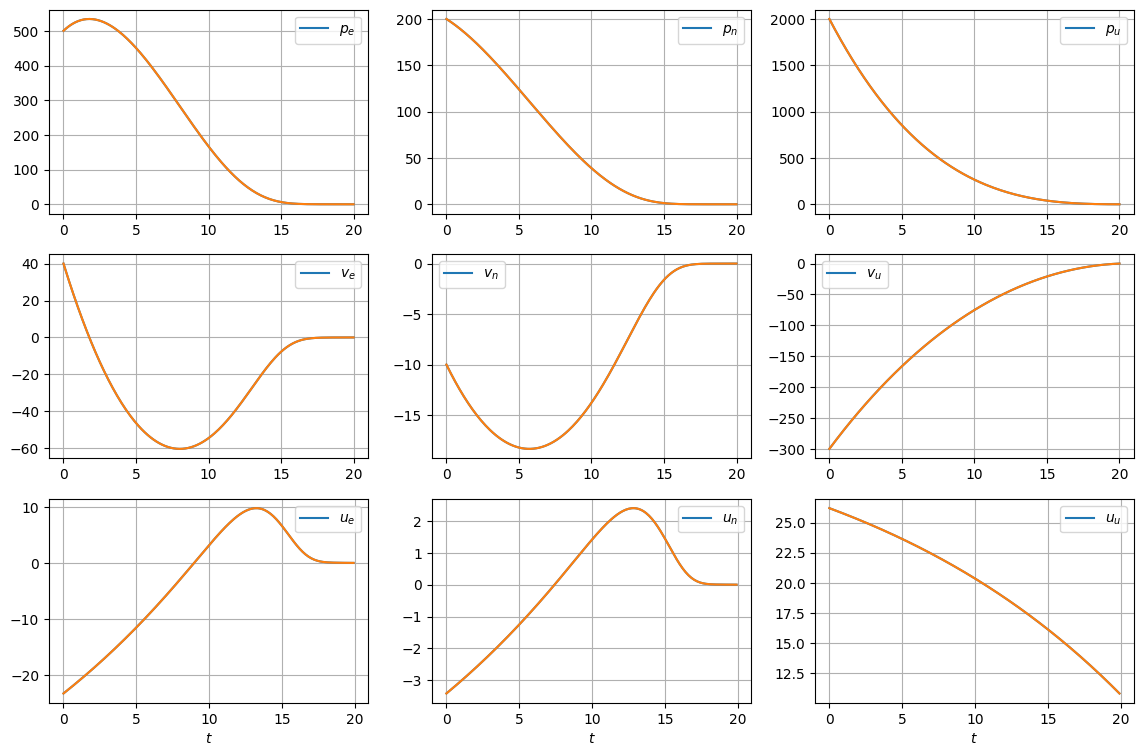

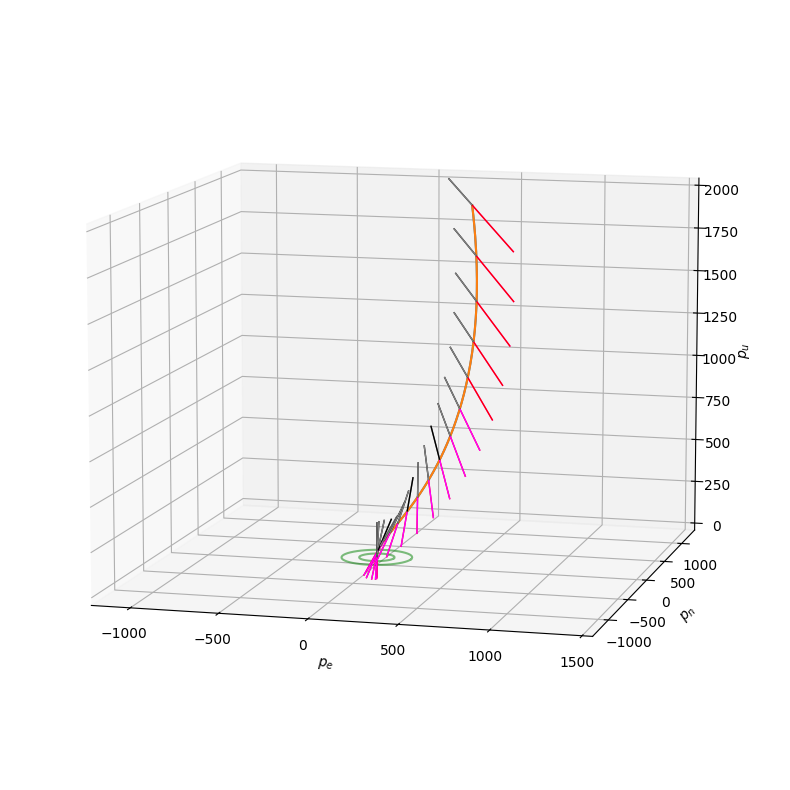

In [34]:
# plots
draw_plots(ts,X_opt,U_opt,ts,x_dp,u_dp)
draw_3d_traj(X_opt,U_opt,x_dp,u_dp)

<br>

## Disturbance sensitivity

_**(Problem 3)**_ Analyze the sensitivity of the two solutions to the random disturbance, by applying the two solution on the the following dynamic system.
Apply the two control solutions on the rocket system under random gust:

$$
x_{t+1} = Ax_t + Bu_t + w_t + b
$$

where $w_t=(0,0,0,w_{e,t}, w_{n,t},w_{u,t})$ represents the disturbance from random gust at time step $t$, and the gust disturbance components $w_{e,t}$, $w_{n,t}$, $w_{u,t}$ are zero mean identically and independently distributed (IID) Gaussian random variables with variance given by $(p_{u,t}/500)^2$ (the gust intensity increasing with altitude). Simulate the stochastic system several times to check consistency.

In [38]:
##################
# your code here

import numpy as np

def simulate_system(A,B,b,x0,U,w):
    """
    오픈 루프 제어열 U 적용 시 난류 w 포함 시스템 시뮬레이션
    A,B,b: 시스템 파라미터
    x0: 초기 상태 (6,)
    U: 제어입력 (m,N)
    w: 난류 (6,N) 형태, w[:3,t]=0, w[3:,t]는 난류성분
    """
    n = x0.shape[0]
    N = U.shape[1]
    x = np.zeros((n,N+1))
    x[:,0] = x0
    for t in range(N):
        x[:,t+1] = A @ x[:,t] + B @ U[:,t] + b + w[:,t]
    return x

def simulate_system_feedback(A,B,b,x0,K,k,w):
    """
    DP 기반 피드백 제어 (u_t = K_t x_t + k_t) 적용 시 난류 w 포함 시스템 시뮬레이션
    A,B,b: 시스템 파라미터
    x0: 초기 상태 (6,)
    K, k: 리스트 형태로 길이 N, K[t]는 (3,6), k[t]는 (3,)
    w: 난류 (6,N)
    """
    n = x0.shape[0]
    N = len(K)
    x = np.zeros((n,N+1))
    u = np.zeros((3,N))
    x[:,0] = x0
    for t in range(N):
        u[:,t] = K[t] @ x[:,t] + k[t]
        x[:,t+1] = A @ x[:,t] + B @ u[:,t] + b + w[:,t]
    return x, u

# 난류 발생 함수
def generate_disturbance(X_trajectory):
    """
    X_trajectory: 난류 없는 상황에서의 상태 궤적 (6,N+1)
    여기서 X_trajectory[2,t] = p_u(t) (고도)
    고도를 사용해 난류 분산 계산 후 난류 샘플링
    """
    N = X_trajectory.shape[1]-1
    w = np.zeros((6,N))
    for t in range(N):
        p_u_t = X_trajectory[2,t]
        sigma = (p_u_t / 500.0)**2
        w[3:,t] = np.random.randn(3)*sigma
    return w

# LS 해법으로 얻은 U_opt, X_opt 가 있다고 가정 (오픈 루프)
# DP 해법으로 얻은 K,k가 있다고 가정 (피드백)

num_sims = 100
positions_end_ls = []
positions_end_dp = []

for sim_id in range(num_sims):
    # 난류 샘플 생성 (난류 없을 때의 X_opt 사용 또는 근사적으로 p_u 변화 가정)
    w_sim = generate_disturbance(X_opt)  # X_opt는 LS 해법으로 구한 nominal trajectory

    # LS 해법 오픈 루프 제어 적용
    x_ls = simulate_system(A,B,b,x_0,U_opt,w_sim)
    positions_end_ls.append(x_ls[:3,-1])  # final position

    # DP 해법 피드백 제어 적용
    # (피드백을 적용하지 않으려면 u_dp = DP 해법으로 구한 open-loop U 사용)
    x_dp, u_dp = simulate_system_feedback(A,B,b,x_0,K,k,w_sim)
    positions_end_dp.append(x_dp[:3,-1])

positions_end_ls = np.array(positions_end_ls)
positions_end_dp = np.array(positions_end_dp)
# 마지막 시뮬레이션의 결과 출력
p_final_dp = positions_end_dp[-1]


print("Terminal position (DP):", p_final_dp)


Terminal position (DP): [ 0.26523006  0.12029036 -0.19528304]


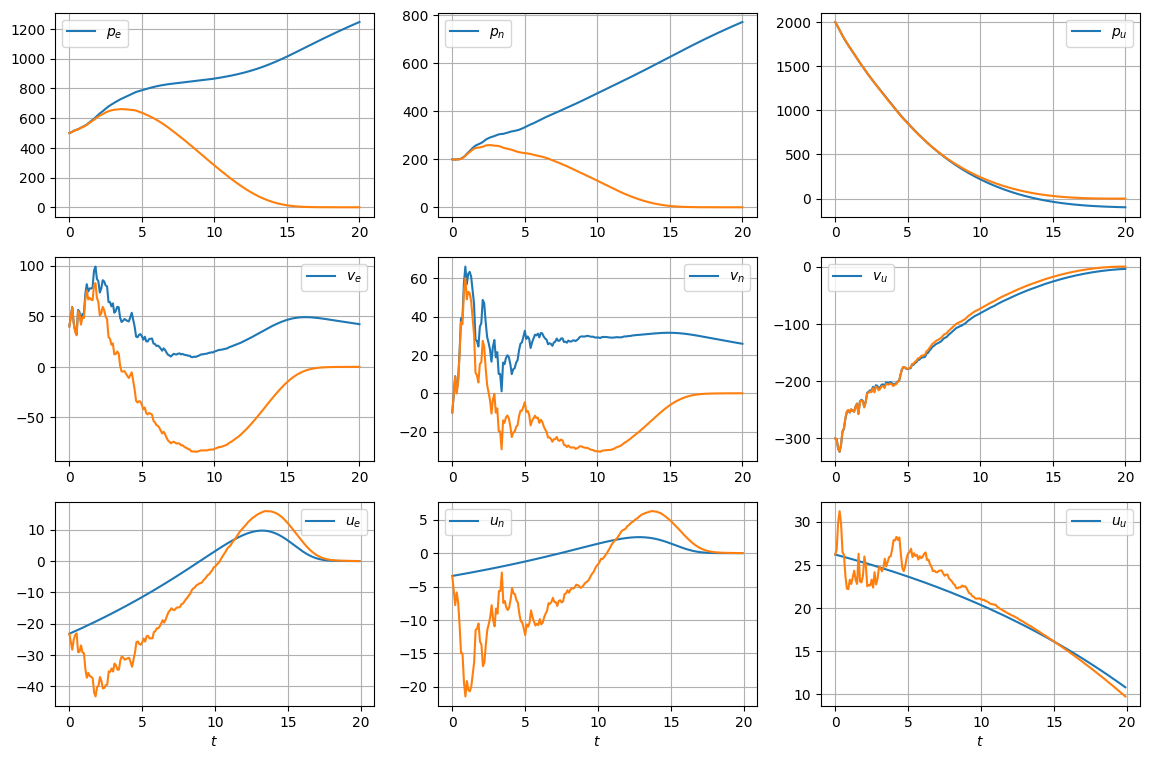

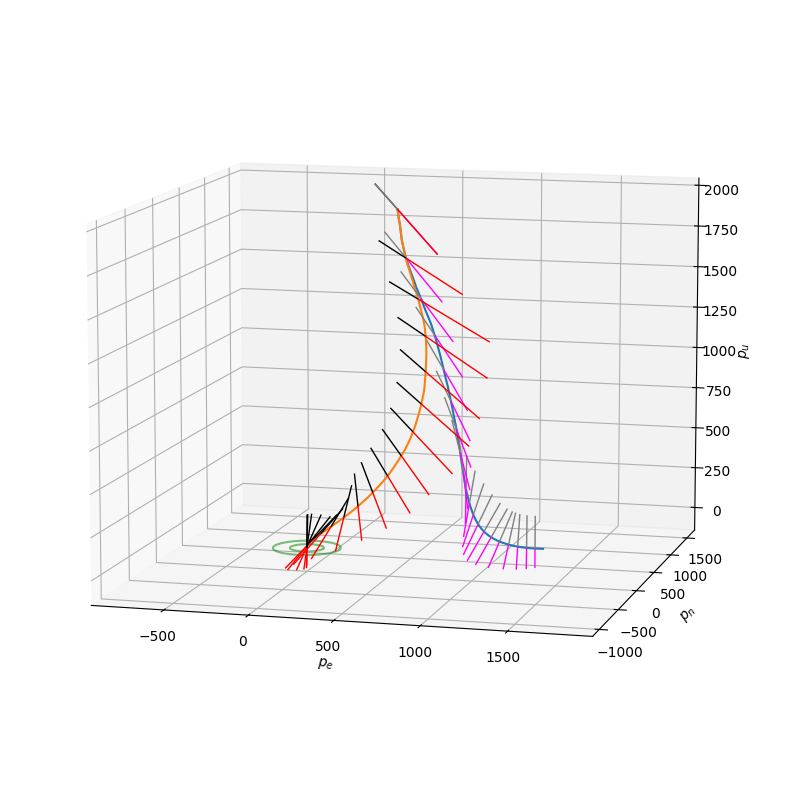

In [40]:
# plots
draw_plots(ts,x_ls,U_opt,ts,x_dp,u_dp)
draw_3d_traj(x_ls,U_opt,x_dp,u_dp)

<br>

## Design your own trajectory

_**(Problem 4)**_ Redesign $Q_0,\dots,Q_N$ and possibly $R_0,\dots,R_{N-1}$ so that the new trajectory looks prettier, safer, and also fuel efficient.



In [ ]:
##################
# your code here


# your code here
##################